In [19]:
# !pip install torchinfo
import torch
print('PyTorch version:', torch.__version__)
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
print('Torchvision version:', torchvision.__version__)
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


In [20]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

import os
# Number of CPU cores
print(os.cpu_count())

GPU name: Tesla P100-PCIE-16GB 

Device is: cuda 

Total number of GPUs: 1
4


In [21]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])   # scale  between [-1,1]

In [22]:
training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

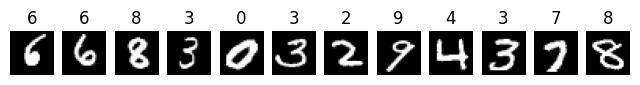

In [23]:
# show 12 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=1, ncols=12, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(12)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='gray')
    ax.set_title(int(training_dataset.targets[inx]), fontsize=12)
    ax.axis(False);

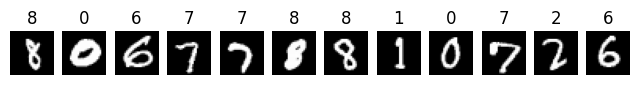

In [24]:
# show 12 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=1, ncols=12, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(12)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='gray')
    ax.set_title(int(test_dataset.targets[inx]), fontsize=12)
    ax.axis(False);

In [25]:
training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True, num_workers=4)

In [26]:
class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):

        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def diffusion_process(self, x, noise, t):
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    def ddpm_sampling(self, model, num_samples, channels, img_size, labels): #
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                # t = (torch.ones(num_samples) * i).long().to(self.device)
                t = torch.full((num_samples,), i, device=self.device, dtype=torch.long)

                pred_noise = model(x, t, labels) #
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect


In [27]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[1][0]
print('Image label:', training_dataset[0][1])
get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

Image label: 5


In [28]:
noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

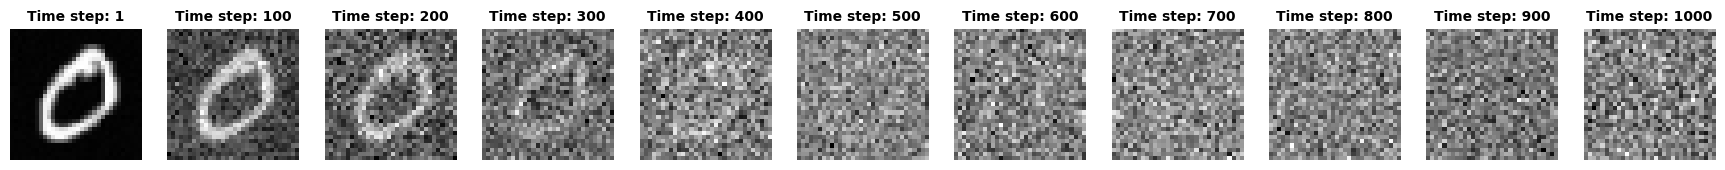

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))

for idx, img in enumerate(noisy_img_stack):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(f'Time step: {t_step[idx]+1}', fontsize=10, fontweight='bold')
    ax[idx].axis(False);

In [30]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()

        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))

    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

In [31]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()

        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)

    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

In [32]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()

        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb


# it is useful control the amount of noise on the time step 

In [33]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()

        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb


# Semantic segmentation (U-Net architecture).

# Image generation (e.g., in diffusion models, where timestep embeddings are crucial).

# Image restoration (where both high-level and fine-grained information needs to be combined).

In [34]:
class Conditional_UNet(nn.Module):
    def __init__(self, t_emb_dim, n_classes, device='cuda'): #
        super(Conditional_UNet, self).__init__()

        self.device = device
        self.t_emb_dim = t_emb_dim
        #
        self.n_classes = n_classes

        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)

        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)

        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        #
        self.embeddings = nn.Embedding(num_embeddings=self.n_classes, embedding_dim=self.t_emb_dim)

    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb

    def forward(self, x, t, labels): #
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        #
        t += self.embeddings(labels)

        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

In [35]:
model = Conditional_UNet(t_emb_dim=256, n_classes=10).to(device)

In [36]:
from torchinfo import summary

summary(
    Conditional_UNet(t_emb_dim=256, n_classes=10).to(device),
    input_data=[
        torch.randn(64, 1, 32, 32).to(device),  # Image
        torch.randn(64).to(device),            # Time embedding index or continuous value
        torch.randint(0, 10, (64,)).to(device)  # Class label
    ]
)


Layer (type:depth-idx)                        Output Shape              Param #
Conditional_UNet                              [64, 1, 32, 32]           --
├─Embedding: 1-1                              [64, 256]                 2,560
├─ResBlock: 1-2                               [64, 64, 32, 32]          --
│    └─Sequential: 2-1                        [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                       [64, 64, 32, 32]          640
│    │    └─GroupNorm: 3-2                    [64, 64, 32, 32]          128
│    │    └─SiLU: 3-3                         [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                       [64, 64, 32, 32]          36,928
│    │    └─GroupNorm: 3-5                    [64, 64, 32, 32]          128
├─DownBlock: 1-3                              [64, 128, 16, 16]         --
│    └─Sequential: 2-2                        [64, 128, 16, 16]         --
│    │    └─MaxPool2d: 3-6                    [64, 64, 16, 16]          --
│    │    

In [38]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [39]:

from torchviz import make_dot
import torch

# model = Conditional_UNet(t_emb_dim=256, n_classes=10).to(device)

# Sample inputs
img =  torch.randn(64, 1, 32, 32).to(device)
t =  torch.randn(64).to(device)
label = torch.randint(0, 10, (64,)).to(device)

# Forward pass
output = model(img, t, label)

# Create the graph
dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('conditional_unet_graph')  # saves to file


'conditional_unet_graph.png'

In [40]:
# summary(Conditional_UNet(t_emb_dim=256, n_classes=10).to(device), input_size=[(64, 1, 32, 32), (64,), (64,)],
#         dtypes=[torch.float, torch.float, torch.long]) #

In [41]:
ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = Conditional_UNet(t_emb_dim=256, n_classes=10).to(device) #
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [42]:
torch.manual_seed(1111)
torch.random.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 20
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []

    for data, labels in tqdm(training_dataloader): #
        model.train()
        data = data.to(device)
        #
        labels = labels.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t, labels) #
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()

    with torch.inference_mode():
        for data, labels in tqdm(test_dataloader): #
            model.eval()
            data = data.to(device)
            #
            labels = labels.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t, labels) #
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)

    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |    ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')

100%|██████████| 156/156 [00:11<00:00, 13.87it/s]


Epoch: 1/20	| Training loss: 0.0583 |    Test loss: 0.0308


100%|██████████| 156/156 [00:11<00:00, 13.90it/s]


Epoch: 2/20	| Training loss: 0.0275 |    Test loss: 0.0262


100%|██████████| 156/156 [00:11<00:00, 13.81it/s]


Epoch: 3/20	| Training loss: 0.0247 |    Test loss: 0.0231


100%|██████████| 156/156 [00:11<00:00, 13.98it/s]


Epoch: 4/20	| Training loss: 0.0228 |    Test loss: 0.0213


100%|██████████| 156/156 [00:11<00:00, 13.82it/s]


Epoch: 5/20	| Training loss: 0.0210 |    Test loss: 0.0200


100%|██████████| 156/156 [00:11<00:00, 13.79it/s]


Epoch: 6/20	| Training loss: 0.0192 |    Test loss: 0.0183


100%|██████████| 156/156 [00:11<00:00, 13.68it/s]


Epoch: 7/20	| Training loss: 0.0184 |    Test loss: 0.0179


100%|██████████| 156/156 [00:11<00:00, 13.71it/s]


Epoch: 8/20	| Training loss: 0.0177 |    Test loss: 0.0171


100%|██████████| 156/156 [00:11<00:00, 13.90it/s]


Epoch: 9/20	| Training loss: 0.0172 |    Test loss: 0.0172


100%|██████████| 156/156 [00:11<00:00, 13.93it/s]


Epoch: 10/20	| Training loss: 0.0168 |    Test loss: 0.0165


100%|██████████| 156/156 [00:11<00:00, 13.87it/s]


Epoch: 11/20	| Training loss: 0.0168 |    Test loss: 0.0168


100%|██████████| 156/156 [00:11<00:00, 13.84it/s]


Epoch: 12/20	| Training loss: 0.0164 |    Test loss: 0.0160


100%|██████████| 156/156 [00:11<00:00, 13.86it/s]


Epoch: 13/20	| Training loss: 0.0161 |    Test loss: 0.0155


100%|██████████| 156/156 [00:11<00:00, 13.86it/s]


Epoch: 14/20	| Training loss: 0.0159 |    Test loss: 0.0156


100%|██████████| 156/156 [00:11<00:00, 13.84it/s]


Epoch: 15/20	| Training loss: 0.0160 |    Test loss: 0.0157


100%|██████████| 156/156 [00:11<00:00, 13.74it/s]


Epoch: 16/20	| Training loss: 0.0156 |    Test loss: 0.0155


100%|██████████| 156/156 [00:11<00:00, 13.84it/s]


Epoch: 17/20	| Training loss: 0.0154 |    Test loss: 0.0154


100%|██████████| 156/156 [00:11<00:00, 13.83it/s]


Epoch: 18/20	| Training loss: 0.0154 |    Test loss: 0.0152


100%|██████████| 156/156 [00:11<00:00, 13.79it/s]


Epoch: 19/20	| Training loss: 0.0156 |    Test loss: 0.0149


100%|██████████| 156/156 [00:11<00:00, 13.86it/s]

Epoch: 20/20	| Training loss: 0.0151 |    Test loss: 0.0153


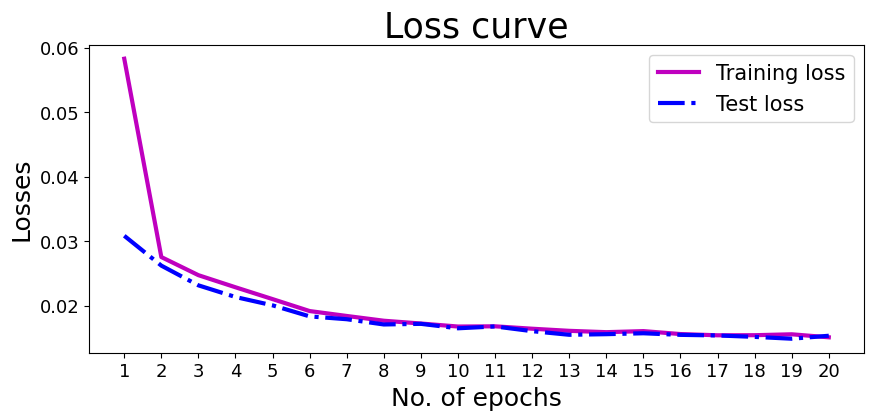

In [43]:
N = np.arange(20) + 1

plt.figure(figsize=(10, 4))
plt.plot(N, training_loss, 'm-', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-.', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=18)
plt.ylabel('Losses', fontsize=18)
plt.xticks(N, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15);

In [46]:
#
y = torch.randint(low=0, high=10, size=(1,)).to(device)
print('Generating the image of:\n', y)

Generating the image of:
 tensor([7], device='cuda:0')


In [47]:
_, collect = ddpm.ddpm_sampling(model=model, num_samples=1, channels=1, img_size=32, labels=y) #

1000it [00:15, 64.87it/s]


In [48]:
step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1]

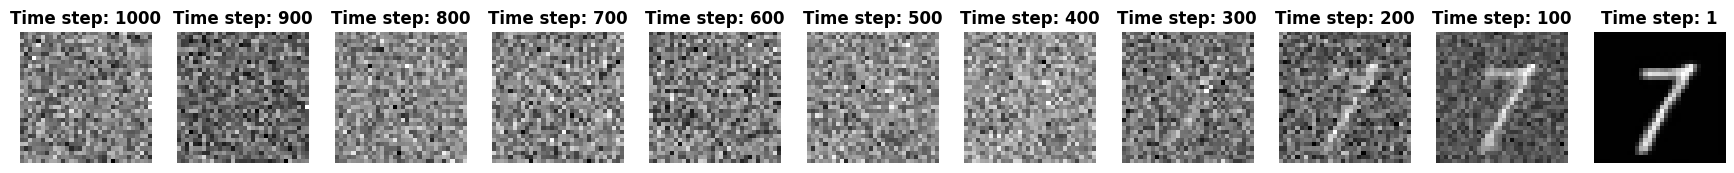

In [49]:
fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))

j = 0
for ax, _ in zip(axis.ravel(), range(11)):
    ax.imshow(collect[j][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {step[j]}', fontweight='bold')
    ax.axis(False)
    j += 1;

In [57]:
#
H = torch.randint(low=0, high=10, size=(64,)).to(device)
print('Generating the images of:\n', H)

Generating the images of:
 tensor([3, 3, 3, 1, 0, 1, 9, 3, 8, 0, 5, 0, 7, 0, 0, 3, 7, 0, 8, 3, 2, 9, 6, 6,
        7, 7, 7, 2, 7, 3, 6, 1, 8, 0, 4, 7, 8, 8, 3, 5, 6, 3, 0, 5, 7, 4, 8, 2,
        9, 7, 8, 9, 5, 5, 9, 7, 9, 1, 1, 7, 2, 9, 5, 3], device='cuda:0')


In [58]:
sampled_imgs, _ = ddpm.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32, labels=y) #

1000it [01:07, 14.81it/s]


In [59]:
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)

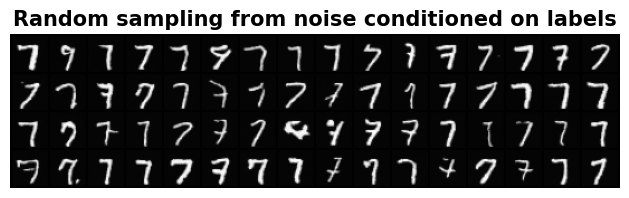

In [60]:
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Random sampling from noise conditioned on labels', fontsize=15, fontweight='bold');

In [61]:
import torchvision
from torchvision.utils import save_image
import os
import torch

# Load MNIST real dataset
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)

# Create a folder for real images
os.makedirs('./real_images', exist_ok=True)

# Save first 1000 images
for idx, (img, _) in enumerate(dataset):
    if idx == 1000:
        break
    # Convert the PIL Image to a PyTorch tensor
    img_tensor = transforms.ToTensor()(img)

    # Before save_image
    img_tensor = img_tensor.repeat(3, 1, 1)  # Convert (1, 32, 32) -> (3, 32, 32)

    
    save_image(img_tensor, f'./real_images/{idx}.png')

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 19.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Install FID package
!pip install pytorch-fid

# Import necessary libraries
import os
import torch
import torchvision
from torchvision.utils import save_image
from pytorch_fid import fid_score
from tqdm import tqdm

# Create directory to save generated images
os.makedirs('generated_images1', exist_ok=True)

# Generate and save images
batch_size = 16  # How many images per batch
total_samples = 1000  # Total images to generate

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for i in tqdm(range(0, total_samples, batch_size)):
        y_batch = torch.randint(low=0, high=10, size=(batch_size,)).to(device)
        sampled_imgs_batch, _ = ddpm.ddpm_sampling(model=model, num_samples=batch_size, channels=1, img_size=32, labels=y_batch)

        for j in range(batch_size):
            # Before saving generated sample
            # sampled_imgs_batch[j] = sampled_imgs_batch[j].repeat(3, 1, 1)

            save_image(sampled_imgs_batch[j].repeat(3,1,1), f"generated_images1/image_{i + j}.png")

print("✅ Generated images saved successfully!")

# Calculate FID score
# Note: Adjust the 'real_images_path' to where your real images are stored.

# real_images_path = './data_src/MNIST/raw'  # Example MNIST dataset path in Kaggle

fid_value = fid_score.calculate_fid_given_paths(
    paths=['real_images','generated_images1'],
    batch_size=batch_size,
    device=device,
    dims=2048
)

print(f"\n🎯 FID Score: {fid_value:.4f}")

  0%|          | 0/63 [00:00<?, ?it/s]
0it [00:00, ?it/s]
2it [00:00, 19.55it/s]
6it [00:00, 29.23it/s]
10it [00:00, 32.01it/s]
14it [00:00, 33.65it/s]
18it [00:00, 34.85it/s]
22it [00:00, 35.61it/s]
26it [00:00, 36.13it/s]
30it [00:00, 36.40it/s]
34it [00:00, 36.57it/s]
38it [00:01, 36.74it/s]
42it [00:01, 36.86it/s]
46it [00:01, 36.81it/s]
50it [00:01, 36.84it/s]
54it [00:01, 36.86it/s]
58it [00:01, 37.00it/s]
62it [00:01, 37.04it/s]
66it [00:01, 37.08it/s]
70it [00:01, 37.14it/s]
74it [00:02, 36.85it/s]
78it [00:02, 36.24it/s]
82it [00:02, 35.76it/s]
86it [00:02, 35.71it/s]
90it [00:02, 35.95it/s]
94it [00:02, 35.77it/s]
98it [00:02, 35.83it/s]
102it [00:02, 35.84it/s]
106it [00:02, 35.83it/s]
110it [00:03, 36.07it/s]
114it [00:03, 36.33it/s]
118it [00:03, 36.55it/s]
122it [00:03, 36.72it/s]
126it [00:03, 36.82it/s]
130it [00:03, 37.00it/s]
134it [00:03, 37.07it/s]
138it [00:03, 37.09it/s]
142it [00:03, 37.14it/s]
146it [00:04, 37.23it/s]
150it [00:04, 37.28it/s]
154it [00:04, 37.32

In [10]:
!git init

Reinitialized existing Git repository in /kaggle/working/.git/


In [11]:
!git add .

In [12]:
!git commit -m "practical file added"

On branch main

Initial commit

nothing to commit (create/copy files and use "git add" to track)


In [13]:
!git config --global user.email deepanshugarhi@gmail.com
!git config --global user.name deepanshu2118

In [6]:
!git commit -m "practical file added"

On branch master

Initial commit

nothing to commit (create/copy files and use "git add" to track)


In [7]:
!git branch -M main 

In [8]:
!git remote add origin https://github.com/deepanshu2118/Diffusion-model.git

In [9]:
!git push -u origin main

error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/deepanshu2118/Diffusion-model.git'
